In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from os import environ, path, mkdir, walk, chdir, scandir


from datetime import datetime, timedelta, date
from random import sample, randint
from math import pow, floor


import joblib
import session_info
from pickle import load, dump

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout
from tensorflow.keras.layers import LSTM, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import to_categorical, plot_model, model_to_dot
from tensorflow.keras.losses import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.losses import MeanSquaredError, MeanSquaredLogarithmicError
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau


from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

2022-09-07 14:43:15.793512: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
now = datetime.now()
print('====================================================================================')
print('*******************     Forcasting Battery Charge       **************************')
print('                          ' + now.strftime("%Y-%m-%d %H:%M:%S"))
print()

*******************     Forcasting Battery Charge       **************************
                          2022-09-07 14:43:28



In [3]:
path_data = './favorita-grocery-sales-forecasting/'

perfix = '' 
file_name =  '' 

# chdir(path_data)

In [4]:
t_stamp = now.strftime('%Y%m%d_%H%M%S')
print('Time Stamp: ', t_stamp)

saved_t_stamp = '' # 
New_training = True


dir_path = './'
fn_dataset = 'formatted_dataset_frac2.csv' # 'formatted_dataset.csv' #'combined_dataset_frac.csv' #'combined_datasets.csv' 


# Select new training or reading saved trained model

if New_training:
    checkpoint_path = t_stamp + '_checkpoint'
    model_load_timestamp = ''
    fn_scaler = t_stamp + '_scaler.pkl'
else:
    checkpoint_path = saved_t_stamp + '_checkpoint' 
    model_load_timestamp = saved_t_stamp
    fn_scaler = saved_t_stamp + '_scaler.pkl'
    
    

model_load_fn =  model_load_timestamp + '_FC_model'

Time Stamp:  20220907_144328


In [5]:
# list files in Kaggle data folder

with scandir() as bag:
    for obj in bag:
        if obj.is_file():
            print(obj.name)

BatteryPredic_DataCleaning_v07.ipynb
.~lock.findings.doc#
1-GrocerySales_EDA_Dask_v01.ipynb
1-GrocerySales_EDA_v01.ipynb
1-GrocerySales_EDA_v02.ipynb
2-Data_Preparation.ipynb
3-Model.ipynb
3-Model_00 (copy).ipynb
3-Model_00-Copy1.ipynb
3-Model_00.ipynb
3-Model_LSTM.ipynb
3-Model_v01.ipynb
Advanced Analytics_Data Science Skills Interview_Forecasting (1).pdf
Battery_ML_Prediction_Model_v02.ipynb
Battery_Prediction_Model_v08.1.ipynb
Battery_Prediction_Model_v08.5.ipynb
Battery_Prediction_Model_v08.ipynb
Battery_Prediction_v04.ipynb
FC_v01.png
findings.doc
kaggle.com-Corporación Favorita Grocery Sales Forecasting.pdf
MinMaxScaler.state
StandardScaler.state
Untitled.ipynb


# Load Dataset

In [6]:

# df_iunit = pd.read_csv('combined_i_unit.csv', sep=',', header='infer', index_col= 0 )
df_iunit = pd.read_csv(path_data+fn_dataset, sep=',', header='infer' , index_col= 0) #
df_iunit

,store_nbr,item_nbr,unit_sales,onpromotion,class,perishable,cluster,dcoilwtico,holiday,weekday,...,city_Santo Domingo,locale_Local,locale_National,locale_Regional,locale_Working,type_A,type_B,type_C,type_D,type_E
6022746,0.849057,-1.646567,3.000,0,0.252287,1,0.8125,-0.615891,0,0.500000,...,0,0,0,0,1,1,0,0,0,0
8358725,0.283019,-0.522891,7.000,0,0.001180,0,0.1250,2.129465,0,0.500000,...,1,0,0,0,1,0,0,1,0,0
2186923,0.924528,-0.669363,2.857,0,0.245205,1,0.8125,0.217092,0,1.000000,...,0,0,0,0,1,1,0,0,0,0
10728,0.566038,-0.670571,4.000,0,0.241074,1,0.5625,2.495258,0,0.333333,...,0,0,0,0,1,0,1,0,0,0
7840985,0.433962,-0.391383,3.000,0,0.000000,0,0.0000,-0.930441,0,0.500000,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9169644,0.660377,-0.074524,39.000,0,0.010918,0,0.5625,-0.221751,1,1.000000,...,0,0,1,0,0,0,0,0,0,1
782579,0.867925,0.803438,1.000,0,0.253172,1,0.8125,-0.087645,0,0.166667,...,0,0,0,0,1,1,0,0,0,0
3794724,0.358491,0.439899,6.000,0,0.008262,0,0.3125,-0.126350,0,0.833333,...,0,0,0,0,1,0,1,0,0,0
592121,0.283019,0.408915,3.000,0,0.017409,0,0.1250,0.657570,1,0.833333,...,1,1,0,0,0,0,0,1,0,0


In [7]:
y_data = df_iunit['unit_sales'].to_numpy()
x_data = df_iunit.drop(columns=['unit_sales']).to_numpy()
print(x_data.shape, y_data.shape)

(813703, 78) (813703,)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.75, random_state=101, shuffle=True)

In [10]:
batch_size = 32
n_epochs = 5

fc_units = [128, 64, 16, 1]

data_shape = (x_train.shape[1])

In [21]:
inputs = Input(shape=data_shape, name='inputs')

x = inputs
x = Dense(units=fc_units[0], activation='relu', name='L1_FC')(x)
x = Dropout(rate=0.2, name='DO_L1')(x)
x = Dense(units=fc_units[1], activation='relu', name='L2_FC')(x)
x = Dropout(rate=0.2, name='DO_L2')(x)
x = Dense(units=fc_units[2], activation='relu', name='L3_FC')(x)
x = Dropout(rate=0.2, name='DO_L3')(x)
# x = Dense(units=fc_units[3], activation='relu', name='L4_FC')(x)
# x = Dropout(rate=0.3, name='DO_L4')(x)
# x = Dense(units=fc_units[4], activation='relu', name='L5_FC')(x)
outputs = Dense(units=fc_units[3], name='output')(x)

model = Model(inputs, outputs, name='model')


model.compile(optimizer=Adam(learning_rate=0.002), loss = MeanSquaredError() , metrics={'output':['mae', 'mape']}) #mean_squared_error  Huber(delta=0.1)



model.summary()

plot_model(model=model, to_file='FC_v01.png', show_shapes=True, show_layer_names=False, rankdir='TB', dpi=200)
model_to_dot(model=model, show_shapes=True, dpi=200)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 78)]              0         
_________________________________________________________________
L1_FC (Dense)                (None, 128)               10112     
_________________________________________________________________
DO_L1 (Dropout)              (None, 128)               0         
_________________________________________________________________
L2_FC (Dense)                (None, 64)                8256      
_________________________________________________________________
DO_L2 (Dropout)              (None, 64)                0         
_________________________________________________________________
L3_FC (Dense)                (None, 16)                1040      
_________________________________________________________________
DO_L3 (Dropout)              (None, 16)                0     

In [12]:
# Defibe callback functions

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True, monitor='val_mae',
                              mode='min', save_best_only=True)

def step_decay(epoch):
    initial_lrate = 0.002
    drop = 0.5
    epochs_drop = 2
    lrate = initial_lrate * pow(drop, floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay, verbose=1)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, 
#                               min_lr=0.001, mode='min', verbose=1)

In [14]:
# save/load the keras model includes architecture + weights + optimizer state
# save train history via pickle


if path.exists(model_load_fn + '.h5'):
    #load keras model if exist
    model = load_model(model_load_fn + '.h5')
    t_stamp = ''
    
    # Check its architecture
    model.summary()
    model.load_weights(checkpoint_path)
    
else:
    try:
        with tf.device('/device:CPU:0'):
            model_hist = model.fit(x_train, y_train, epochs=n_epochs,
                                   validation_data=(x_test, y_test),
                                   callbacks=[cp_callback, lrate], # reduce_lr
                                   shuffle=False, batch_size=batch_size, verbose = 2)
            
            model_save_fn = t_stamp + '_FC_model'
            
            # save the model to a h5 file
            model.save(model_save_fn + '.h5')
            # save train history to a pkl file
            with open(model_save_fn + '_HistoryDict.pkl', 'wb') as h_file:
                dump(model_hist.history, h_file)
    except RuntimeError as e:
        print(e)
    

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.002.
19072/19072 - 61s - loss: 325.8953 - mae: 6.9993 - mape: 196.8530 - val_loss: 331.3025 - val_mae: 8.0033 - val_mape: 240.7107
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
19072/19072 - 60s - loss: 323.2893 - mae: 6.9986 - mape: 197.5522 - val_loss: 311.8445 - val_mae: 7.3607 - val_mape: 216.3093
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
19072/19072 - 60s - loss: 322.4071 - mae: 6.9897 - mape: 197.3796 - val_loss: 311.7201 - val_mae: 7.3848 - val_mape: 220.2139
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005.
19072/19072 - 59s - loss: 321.3144 - mae: 6.9886 - mape: 197.5083 - val_loss: 306.6921 - val_mae: 7.1535 - val_mape: 210.3926
Epoch 5/5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0005.
19072/19072 - 59s - loss: 320.6405 - mae: 6.9795 - mape: 197.0205 - val_loss: 306.1938 - val_mae: 7

In [15]:
# load train history via pickle file

if path.exists(model_load_fn + '_HistoryDict.pkl'):
    model_hist = load(open(model_load_fn + '_HistoryDict.pkl', 'rb'))
    train_loss = model_hist['loss']
    val_loss = model_hist['val_loss']
    mae_val = model_hist['mae']
    print('Loaded history file: ', model_load_fn + '_HistoryDict.pkl')
    print(model_hist.keys())
    
else:
    train_loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']
    train_mae = model_hist.history['mae']
    val_mae = model_hist.history['val_mae']

In [17]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test) #, batch_size=32
print("test loss, test MAE, test MAPE:", results)

Evaluate on test data
6358/6358 [==============================] - 12s 2ms/step - loss: 306.1938 - mae: 7.1025 - mape: 207.3509
test loss, test MAE, test MAPE: [306.19378662109375, 7.102487087249756, 207.3508758544922]


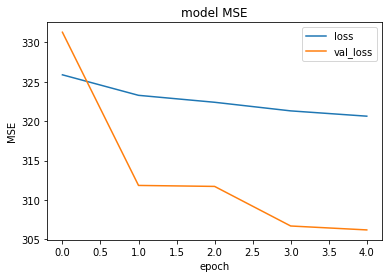

In [18]:
intial_step = 0
plt.plot(train_loss[intial_step:], label='loss')
plt.plot(val_loss[intial_step:], label='val_loss');
# plt.plot(mae_val[intial_step:], label='MAE_loss');

plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')

plt.legend()
plt.show();

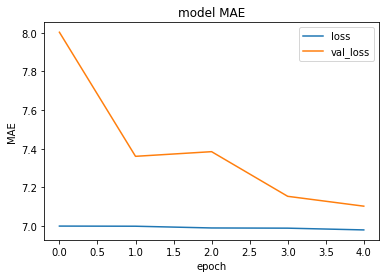

In [19]:
intial_step = 0
plt.plot(train_mae[intial_step:], label='loss')
plt.plot(val_mae[intial_step:], label='val_loss');
# plt.plot(mae_val[intial_step:], label='MAE_loss');

plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')

plt.legend()
plt.show();

In [20]:
session_info.show(html=False, cpu=True, dependencies=None, std_lib=True, 
                  private=False, write_req_file=True, 
                  req_file_name="Retail_requirements.txt")

-----
datetime            NA
joblib              1.1.0
math                NA
matplotlib          3.5.1
numpy               1.19.5
os                  NA
pandas              1.4.0
posix               NA
posixpath           NA
pydot               1.4.2
random              NA
session_info        1.0.0
sklearn             1.0.2
tensorflow          2.4.1
-----
IPython             8.2.0
jupyter_client      7.1.2
jupyter_core        4.9.2
notebook            6.4.8
-----
Python 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) [GCC 10.3.0]
Linux-5.15.0-46-generic-x86_64-with-glibc2.31
48 logical CPU cores, x86_64
-----
Session information updated at 2022-09-07 14:52
